In [1]:
import os
import pickle
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
random.seed(2022)

### Loading data

In [3]:
# load part-of-speech triplets and function words;
# they will later be used as features

POS_TRIGRAMS = pickle.load(open('english/pos_trigrams.pkl', 'rb'))
FUNCTION_WORDS = pickle.load(open('english/function_words.pkl', 'rb'))

In [4]:
toefl_dir = "../data/toefl/"
locness_dir = "../data/locness/"

toefl_meta = "/home/uliana/Dropbox/Projects/EFL/TOEFL/TOEFL/data/index.csv"

In [5]:
# read metadata of the TOEFL corpus
metadata = pd.read_csv(toefl_meta)

In [6]:
# load texts from the TOEFL corpus

metadata['Filename'] = toefl_dir + metadata['Filename']
by_level = metadata.groupby('Score Level')

files_high = metadata.loc[by_level.groups['high'], 'Filename']
files_medium = metadata.loc[by_level.groups['medium'], 'Filename']
files_low = metadata.loc[by_level.groups['low'], 'Filename']

In [7]:
# load texts from the LOCNESS corpus
files_native = os.listdir(locness_dir)
files_native = [locness_dir + file for file in files_native]

In [9]:
def load_essays(files):
    for file in files:
        with open(file, 'r') as f:
            yield f.read().strip().replace("\n", " ")            

In [17]:
high = load_essays(files_high)

In [42]:
essays_high = list(load_essays(files_high))
essays_medium = list(load_essays(files_medium))
essays_low = list(load_essays(files_low))
essays_native = list(load_essays(files_native))

print(f"Number of essays on level NATIVE: {len(essays_native)}")
print(f"Number of essays on level HIGH: {len(essays_high)}")
print(f"Number of essays on level MEDIUM: {len(essays_medium)}")
print(f"Number of essays on level LOW: {len(essays_low)}")

Number of essays on level NATIVE: 412
Number of essays on level HIGH: 4202
Number of essays on level MEDIUM: 6568
Number of essays on level LOW: 1330


### Extract features

In [43]:
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
def get_function_words(chunk):
    words = [word.split("_")[0] for word in chunk]
    words = [word for word in words if word in FUNCTION_WORDS]
    return " ".join(words)

def get_pos(chunk):
    words = [word.split("_")[1] for word in chunk]
    return " ".join(words)

def get_labels(label, chunks):
    return [label for i in range(len(chunks))]

In [45]:
# create a vector of labels for each class
labels = (["low"] * len(essays_low) +
          ["med"] * len(essays_medium) +
          ["high"] *len(essays_high) +
          ["nat"] * len(essays_native))
print(len(labels))

12512


In [46]:
fw_vectors = []
pos_vectors = []

for essay in essays_low + essays_medium + essays_high + essays_native:
    fw = get_function_words(essay.split())
    fw_vectors.append(fw)
    
    pos = get_pos(essay.split())
    pos_vectors.append(pos)

In [47]:
len(fw_vectors), len(pos_vectors)

(12512, 12512)

#### TF-IDF transformation

In [48]:
# perform TF-IDF transformation on function words vectors
fw_vectorizer = TfidfVectorizer()
fw_vectorizer.fit(fw_vectors)
fw_corpus = fw_vectorizer.transform(fw_vectors)
fw_corpus

<12512x375 sparse matrix of type '<class 'numpy.float64'>'
	with 721492 stored elements in Compressed Sparse Row format>

In [49]:
fw_vectorizer.get_feature_names_out()[:10]

array(['about', 'above', 'accordingly', 'actual', 'actually', 'after',
       'afterward', 'afterwards', 'again', 'against'], dtype=object)

In [50]:
# perform TF-IDF transformation on PoS vectors

pos_vectorizer = TfidfVectorizer(ngram_range=(3,3))
pos_vectorizer.fit(pos_vectors)
pos_corpus = pos_vectorizer.transform(pos_vectors)
pos_corpus

<12512x2839 sparse matrix of type '<class 'numpy.float64'>'
	with 2242329 stored elements in Compressed Sparse Row format>

In [51]:
pos_vectorizer.get_feature_names_out()

array(['adj adj adj', 'adj adj adp', 'adj adj adv', ...,
       'verb verb propn', 'verb verb sconj', 'verb verb verb'],
      dtype=object)

In [52]:
print(len(fw_vectorizer.get_feature_names_out()))
print(len(pos_vectorizer.get_feature_names_out()))

375
2839


In [53]:
# for each essay, combine two vectors into one
corpus = scipy.sparse.hstack([fw_corpus, pos_corpus], format='csr')
corpus

<12512x3214 sparse matrix of type '<class 'numpy.float64'>'
	with 2963821 stored elements in Compressed Sparse Row format>

In [54]:
print(f"Total number of essays: {corpus.shape[0]}.")
print(f"Total number of features: {corpus.shape[1]}.")

Total number of essays: 12512.
Total number of features: 3214.


### Oversampling

In [55]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

In [56]:
labels_counter = Counter(labels)

print("Number of observations per class:")
for key in labels_counter:
    print(f"\t{key}\t{labels_counter[key]}")

Number of observations per class:
	low	1330
	med	6568
	high	4202
	nat	412


#### Create one class for non-native essays

In [57]:
y = np.array(labels)
y[np.where(y != "nat")] = "nnat"

labels_counter = Counter(y)
print("Number of observations per class:")
for key in labels_counter:
    print(f"\t{key}\t{labels_counter[key]}")

Number of observations per class:
	nnat	12100
	nat	412


In [59]:
undersample = RandomUnderSampler(random_state=2022)
X_resampled, y_resampled = undersample.fit_resample(corpus, y)

labels_counter = Counter(y_resampled)
print("Number of observations per class after undersampling:")
for key in labels_counter:
    print(f"\t{key}\t{labels_counter[key]}")

Number of observations per class after undersampling:
	nat	412
	nnat	412


### Classification

In [60]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [61]:
fold = StratifiedShuffleSplit(n_splits=10, test_size=0.4, random_state=0)
clf = LogisticRegression()

for train_idx, test_idx in fold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy: = {:.3f}".format(clf.score(X_test, y_test)), end=' \t')
    print("F-score = {:.3f}".format(f1_score(y_test, y_pred, average='micro')))

Accuracy: = 0.948 	F-score = 0.948
Accuracy: = 0.921 	F-score = 0.921
Accuracy: = 0.927 	F-score = 0.927
Accuracy: = 0.948 	F-score = 0.948
Accuracy: = 0.939 	F-score = 0.939
Accuracy: = 0.955 	F-score = 0.955
Accuracy: = 0.958 	F-score = 0.958
Accuracy: = 0.930 	F-score = 0.930
Accuracy: = 0.936 	F-score = 0.936
Accuracy: = 0.955 	F-score = 0.955


In [62]:
fold = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
clf = LinearSVC()

for train_idx, test_idx in fold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy: = {:.3f}".format(clf.score(X_test, y_test)), end=' \t')
    print("F-score = {:.3f}".format(f1_score(y_test, y_pred, average='micro')))

Accuracy: = 0.956 	F-score = 0.956
Accuracy: = 0.960 	F-score = 0.960
Accuracy: = 0.948 	F-score = 0.948
Accuracy: = 0.976 	F-score = 0.976
Accuracy: = 0.976 	F-score = 0.976
Accuracy: = 0.948 	F-score = 0.948
Accuracy: = 0.956 	F-score = 0.956
Accuracy: = 0.968 	F-score = 0.968
Accuracy: = 0.952 	F-score = 0.952
Accuracy: = 0.940 	F-score = 0.940


In [63]:
def get_distance(clf, point):
    dfunc = clf.decision_function(point)
    w_norm = np.linalg.norm(clf.coef_)
    dist = dfunc / w_norm
    return dist

In [64]:
orig_y = np.array(labels)

In [65]:
points_low = corpus[np.where(orig_y == "low")]
dist = get_distance(clf, points_low)
print("Proficiency level: low\n----------------------")
print(f"Median distance from hyperplane: {np.median(dist).round(4)}")
print(f"Mean distance from hyperplane: {np.mean(dist).round(4)}")
print("MAD:", scipy.stats.median_abs_deviation(dist).round(4))

Proficiency level: low
----------------------
Median distance from hyperplane: 0.1246
Mean distance from hyperplane: 0.1222
MAD: 0.0374


In [66]:
points_med = corpus[np.where(orig_y == "med")]
dist = get_distance(clf, points_med)
print("Proficiency level: medium\n-------------------------")
print(f"Median distance from hyperplane: {np.median(dist).round(4)}")
print(f"Mean distance from hyperplane: {np.mean(dist).round(4)}")
print("MAD:", scipy.stats.median_abs_deviation(dist).round(4))

Proficiency level: medium
-------------------------
Median distance from hyperplane: 0.1089
Mean distance from hyperplane: 0.1085
MAD: 0.0355


In [67]:
points_high = corpus[np.where(orig_y == "high")]
dist = get_distance(clf, points_high)
print("Proficiency level: high\n-----------------------")
print(f"Median distance from hyperplane: {np.median(dist).round(4)}")
print(f"Mean distance from hyperplane: {np.mean(dist).round(4)}")
print("MAD:", scipy.stats.median_abs_deviation(dist).round(4))

Proficiency level: high
-----------------------
Median distance from hyperplane: 0.0809
Mean distance from hyperplane: 0.0795
MAD: 0.0368


In [68]:
points_nat = corpus[np.where(orig_y == "nat")]
dist = get_distance(clf, points_nat)
print("Proficiency level: native\n-------------------------")
print(f"Median distance from hyperplane: {np.median(dist).round(4)}")
print(f"Mean distance from hyperplane: {np.mean(dist).round(4)}")
print("MAD:", scipy.stats.median_abs_deviation(dist).round(4))

Proficiency level: native
-------------------------
Median distance from hyperplane: -0.0998
Mean distance from hyperplane: -0.1082
MAD: 0.025


## Distribution of distances

In [69]:
distances = get_distance(clf, corpus)
distances_df = pd.DataFrame(data=zip(distances, labels), columns=['distance', 'level'])
distances_df.head()

,distance,level
0,0.138074,low
1,0.150844,low
2,0.123528,low
3,0.056000,low
4,0.078732,low


In [70]:
# apply colors for each level
COLORS = {
    "low": 'red',
    'med': 'yellow',
    'high': 'green',
    'nat': 'blue'
}
distances_df['color'] = distances_df['level'].map(COLORS)

In [71]:
# creating a subset of non-native speakers
nonnatives = distances_df[distances_df['level'] != 'nat']

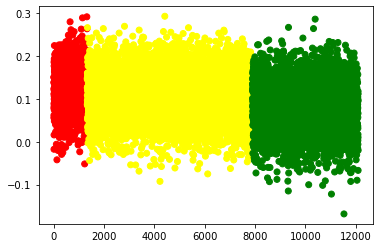

In [72]:
# sns.scatterplot(x=range(len(nonnatives)),
#                 y=nonnatives["distance"],
#                 c=nonnatives["color"], marker='o')
fig, ax = plt.subplots()
ax.scatter(x=range(len(nonnatives)), y=nonnatives["distance"], c=nonnatives["color"])

<AxesSubplot:xlabel='level', ylabel='distance'>

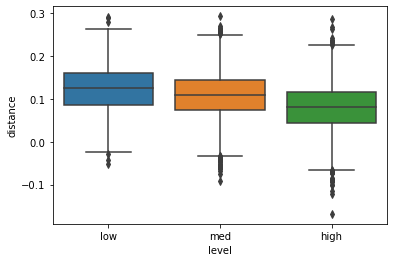

In [73]:
sns.boxplot(x='level', y='distance', data=nonnatives)

<AxesSubplot:xlabel='distance', ylabel='Count'>

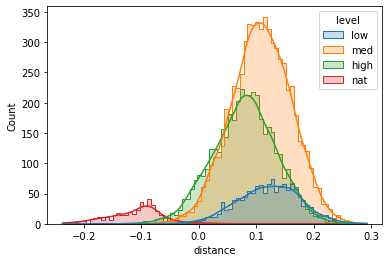

In [74]:
sns.histplot(x='distance', data=distances_df, hue='level', kde=True, element='step')

In [75]:
nonatives = distances_df[distances_df['level'].isin(['low', 'med', 'high'])]

<AxesSubplot:xlabel='distance', ylabel='Count'>

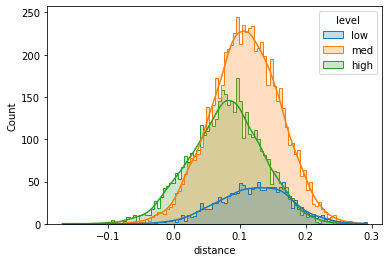

In [76]:
sns.histplot(x='distance', data=nonnatives, hue='level', kde=True,
             element='step', bins=100)

<AxesSubplot:xlabel='distance', ylabel='Count'>

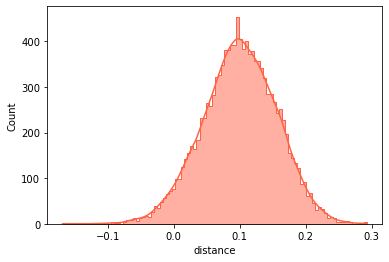

In [77]:
sns.histplot(x='distance', data=nonnatives, kde=True, element='step', bins=100, color='tomato')

## Clustering

In [79]:
# for each chunk, get distances from the hyperplane 
low_dist = get_distance(clf, points_low)
med_dist = get_distance(clf, points_med)
high_dist = get_distance(clf, points_high)
nat_dist = get_distance(clf, points_nat)

In [80]:
# calculate mean distance for each level
low_centroid = np.mean(low_dist)
high_centroid = np.mean(high_dist)
med_centroid = np.mean(med_dist)

In [81]:
pred_centroid = []

for i, row in distances_df.iterrows():
    dist = row['distance']
    
    dist_dict = {
        'high': abs(high_centroid - dist),
        'med': abs(med_centroid - dist),
        'low': abs(low_centroid - dist)
    }
    max_centroid = sorted(dist_dict, key=lambda x: dist_dict[x])[0]
    pred_centroid.append(max_centroid)

In [82]:
distances_df['pred centroid'] = pred_centroid

In [83]:
print("Overall accuracy of the approach: {:.2%}".format(
    accuracy_score(distances_df['level'], distances_df['pred centroid'])))

Overall accuracy of the approach: 34.44%


In [84]:
high_df = distances_df[distances_df['level'] == 'high']
print("Accuracy for level HIGH: {:.2%}".format(
    accuracy_score(high_df['level'], high_df['pred centroid'])))

Accuracy for level HIGH: 59.38%


In [85]:
med_df = distances_df[distances_df['level'] == 'med']
print("Accuracy for level MEDIUM: {:.2%}".format(
    accuracy_score(med_df['level'], med_df['pred centroid'])))

Accuracy for level MEDIUM: 16.29%


In [86]:
low_df = distances_df[distances_df['level'] == 'low']
print("Accuracy for level LOW: {:.2%}".format(
    accuracy_score(low_df['level'], low_df['pred centroid'])))

Accuracy for level LOW: 55.94%


In [88]:
from sklearn.metrics import classification_report

In [94]:
distances_df_nnat = distances_df[distances_df['level'] != 'nat']

In [95]:
print(classification_report(distances_df_nnat['level'], distances_df_nnat['pred centroid']))

              precision    recall  f1-score   support

        high       0.46      0.59      0.52      4202
         low       0.16      0.56      0.24      1330
         med       0.57      0.16      0.25      6568

    accuracy                           0.36     12100
   macro avg       0.39      0.44      0.34     12100
weighted avg       0.48      0.36      0.34     12100



### Make predictions: native vs nonnative

In [42]:
y_pred = clf.predict(corpus)
y_true = ['nnat'] * len(labels)

NameError: name 'clf' is not defined

In [ ]:
print(f"accuracy on individual essays: {accuracy_score(y_true, y_pred):.2%}")

### Clustering

In [ ]:
distances = get_distance(clf, new_corpus)
distances_df = pd.DataFrame(data=zip(distances, labels), columns=['distance', 'level'])
distances_df.head()

In [ ]:
# apply colors for each level
COLORS = {
    "low": 'red',
    'med': 'yellow',
    'high': 'green',
    'nat': 'blue'
}
distances_df['color'] = distances_df['level'].map(COLORS)

In [ ]:
# creating a subset of non-native speakers
nonnatives = distances_df[distances_df['level'] != 'nat']

# sns.scatterplot(x=range(len(nonnatives)),
#                 y=nonnatives["distance"],
#                 c=nonnatives["color"], marker='o')
fig, ax = plt.subplots()
ax.scatter(x=range(len(nonnatives)), y=nonnatives["distance"], c=nonnatives["color"])

In [ ]:
sns.boxplot(x='level', y='distance', data=nonnatives)

In [ ]:
pred_centroid = []

for i, row in distances_df.iterrows():
    dist = row['distance']
    
    dist_dict = {
        'high': abs(high_centroid - dist),
        'med': abs(med_centroid - dist),
        'low': abs(low_centroid - dist)
    }
    max_centroid = sorted(dist_dict, key=lambda x: dist_dict[x])[0]
    pred_centroid.append(max_centroid)
distances_df['pred centroid'] = pred_centroid

In [ ]:
print("Overall accuracy of the approach: {:.2%}".format(
    accuracy_score(distances_df['level'], distances_df['pred centroid'])))

In [ ]:
high_df = distances_df[distances_df['level'] == 'high']
print("Accuracy for high level: {:.2%}".format(
    accuracy_score(high_df['level'], high_df['pred centroid'])))

In [ ]:
med_df = distances_df[distances_df['level'] == 'med']
print("Accuracy for high level: {:.2%}".format(
    accuracy_score(med_df['level'], med_df['pred centroid'])))

In [ ]:
low_df = distances_df[distances_df['level'] == 'low']
print("Accuracy for high level: {:.2%}".format(
    accuracy_score(low_df['level'], low_df['pred centroid'])))

In [ ]:
print(classification_report(distances_df['level'], distances_df['pred centroid']))